# Replacing the CEO funds an average startup 1M more dollars

In [2]:
import pandas as pd
import numpy as np
milestone = pd.read_csv("../data/milestones.csv")
objects = pd.read_csv("../data/objects.csv")
relationships = pd.read_csv("../data/relationships.csv")
people = pd.read_csv("../data/people.csv")

In [62]:
relationships['isCEO'] = relationships.title.apply(lambda x: "CEO" in str(x) or
                                                   "Chief Executive Officer" in str(x) or
                                                   "Founder" in str(x))

In [63]:
relationships.groupby(["isCEO", "is_past"]).count()

id  relationship_id  person_object_id  \
isCEO is_past                                              
False 0        169509           169509            169509   
      1        140420           140420            140420   
True  0         72506            72506             72506   
      1         20443            20443             20443   

               relationship_object_id  start_at  end_at  sequence   title  \
isCEO is_past                                                               
False 0                        169509     67343       0    169509  161920   
      1                        140420     91106   87871    140420  134665   
True  0                         72506     34536       0     72506   72506   
      1                         20443     14010   13175     20443   20443   

               created_at  updated_at  
isCEO is_past                          
False 0            169509      169509  
      1            140420      140420  
True  0             72506       72506  
      1             20443       20443

In [197]:
funding_rounds = pd.read_csv("../data/funding_rounds.csv")

In [198]:
# funding_rounds = funding_rounds.replace(to_replace="crowd", value="0")
# funding_rounds = funding_rounds.replace(to_replace="crowd_equity", value="0")
# funding_rounds = funding_rounds.replace(to_replace="seed", value="1")
# funding_rounds = funding_rounds.replace(to_replace="angel", value="2")
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "debt_round"]
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "grant"]
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "post_ipo_debt"]
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "convertible"]
funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "crowd"]
funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "crowd_equity"]
funding_rounds = funding_rounds[funding_rounds['raised_amount_usd'] != 0]

In [199]:
funding_rounds['funding_round_code'].unique()

array(['b', 'angel', 'a', 'seed', 'c', 'd', 'unattributed', 'debt_round',
       'e', 'f', 'private_equity', 'post_ipo_equity', 'grant',
       'post_ipo_debt', 'partial', 'convertible', 'g', 'secondary_market'],
      dtype=object)

In [200]:
funding_rounds["funding_round_num"] = funding_rounds.groupby("object_id")["funded_at"].rank("dense", ascending=True)

In [201]:
# Funding matrix
funding_matrix = funding_rounds.pivot_table(values="raised_amount_usd",
                           index="object_id",
                           columns='funding_round_num')
funding_matrix

funding_round_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
object_id,,,,,,,,,,,,,,,
c:1,5250000.0,9500000.0,25000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:1001,5000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:10015,2000000.0,9000000.0,2069200.0,12000000.0,43000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:100155,375293.0,6500000.0,3250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:10018,8000000.0,10000000.0,15000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c:99853,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:9989,600000.0,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c:9994,250000.0,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
relationships_CEO = relationships[relationships['isCEO']]
relationships_CEO = relationships_CEO[relationships_CEO['is_past']==1] # Past CEO
relationships_CEO = relationships_CEO[np.logical_not(relationships_CEO.end_at.isna())] # Those have registered end date

In [203]:
fd_rounds = funding_rounds.merge(relationships_CEO[['relationship_object_id', 'end_at']],
                     how='inner', left_on='object_id',
                     right_on='relationship_object_id')
fd_rounds['CEO_changed'] = fd_rounds['end_at']>=fd_rounds['funded_at']

In [204]:
fd = fd_rounds[fd_rounds.CEO_changed == False].groupby("object_id").min()['funding_round_num']
fd = fd.reset_index()
X = funding_matrix.merge(fd, how='left', left_on='object_id', right_on='object_id')

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  """Entry point for launching an IPython kernel.


In [217]:
X[X['funding_round_num']==3].mean() - X[X['funding_round_num'].isna()].mean()

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


1.0                 -1.769404e+06
2.0                  1.448170e+06
3.0                  1.367165e+06
4.0                 -2.234598e+06
5.0                 -1.794576e+06
6.0                 -2.400104e+06
7.0                  6.542201e+06
8.0                 -2.810522e+07
9.0                 -1.498332e+06
10.0                -1.520057e+07
11.0                          NaN
12.0                          NaN
13.0                          NaN
14.0                          NaN
15.0                          NaN
funding_round_num             NaN
dtype: float64

In [218]:
import matplotlib.pyplot as plt

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


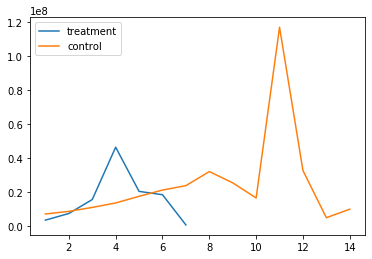

In [230]:
plt.plot(X[X['funding_round_num']==6].mean()[:-1])
plt.plot(X[X['funding_round_num'].isna()].mean()[:-1])
plt.legend(['treatment', 'control'])

In [231]:
people

,id,object_id,first_name,last_name,birthplace,affiliation_name
0,1,p:2,Ben,Elowitz,NaN,Blue Nile
1,2,p:3,Kevin,Flaherty,NaN,Wetpaint
2,3,p:4,Raju,Vegesna,NaN,Zoho
3,4,p:5,Ian,Wenig,NaN,Zoho
4,5,p:6,Kevin,Rose,"Redding, CA",i/o Ventures
...,...,...,...,...,...,...
226704,226705,p:268589,John,Pins,NaN,Unaffiliated
226705,226706,p:268590,David,Schulhof,NaN,Unaffiliated
226706,226707,p:268592,Matthew,D. Rosen,NaN,Unaffiliated
226707,226708,p:268593,Gordon,Hutchins,NaN,Unaffiliated
